In [1]:
# -*- coding: utf-8 -*-
"""
ET₀ Prediction with XGBoost (fast version – no hyperparameter tuning)
Dataset: Sri Lanka Weather Dataset (Kaggle)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import shap
import joblib
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ------------------------------
# 1. Load data
# ------------------------------
# In Colab, upload the file or mount Drive and adjust the path accordingly.
# For this example we assume the file is in the current directory.
df = pd.read_csv('SriLanka_Weather_Dataset.csv')

# Convert 'time' to datetime and sort
df['time'] = pd.to_datetime(df['time'])
df.sort_values('time', inplace=True)


In [3]:
# ------------------------------
# 2. Feature engineering
# ------------------------------
df['mean_temp'] = (df['temperature_2m_max'] + df['temperature_2m_min']) / 2
df['diurnal_range'] = df['temperature_2m_max'] - df['temperature_2m_min']
df['wet_hours'] = df['precipitation_hours']   # proxy for humidity

# Features and target
features = [
    'mean_temp',
    'diurnal_range',
    'shortwave_radiation_sum',
    'windspeed_10m_max',
    'precipitation_sum',
    'wet_hours',
    'latitude',
    'longitude',
    'elevation'
]
target = 'et0_fao_evapotranspiration'

# Drop rows with missing target or features
df = df.dropna(subset=features + [target])

X = df[features].copy()
y = df[target].copy()

print(f"Total usable samples: {len(X)}")

Total usable samples: 110309


In [5]:
# ------------------------------
# 3. Chronological split
# ------------------------------
train_mask = df['time'].dt.year <= 2019
val_mask = (df['time'].dt.year >= 2020) & (df['time'].dt.year <= 2021)
test_mask = df['time'].dt.year == 2022

X_train, y_train = X[train_mask], y[train_mask]
X_val, y_val = X[val_mask], y[val_mask]
X_test, y_test = X[test_mask], y[test_mask]

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}, Test size: {len(X_test)}")

Train size: 82501, Validation size: 16082, Test size: 8030


In [6]:
# ------------------------------
# 4. Train default XGBoost model
# ------------------------------
# (Skip hyperparameter tuning for speed. You can add tuning later if needed.)
model = xgb.XGBRegressor(objective='reg:squarederror',
                          n_estimators=200,
                          max_depth=5,
                          learning_rate=0.1,
                          subsample=0.8,
                          colsample_bytree=0.8,
                          random_state=42)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [7]:
# ------------------------------
# 5. Evaluate on validation set (optional) and test set
# ------------------------------
def evaluate(y_true, y_pred, dataset_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n--- {dataset_name} ---")
    print(f"RMSE: {rmse:.4f} mm/day")
    print(f"MAE : {mae:.4f} mm/day")
    print(f"R²  : {r2:.4f}")
    return rmse, mae, r2

y_val_pred = model.predict(X_val)
evaluate(y_val, y_val_pred, "Validation")

y_test_pred = model.predict(X_test)
evaluate(y_test, y_test_pred, "Test")


--- Validation ---
RMSE: 0.1328 mm/day
MAE : 0.0910 mm/day
R²  : 0.9824

--- Test ---
RMSE: 0.1399 mm/day
MAE : 0.0949 mm/day
R²  : 0.9794


(np.float64(0.13986356916041578), 0.09488207657162012, 0.9794067150913718)

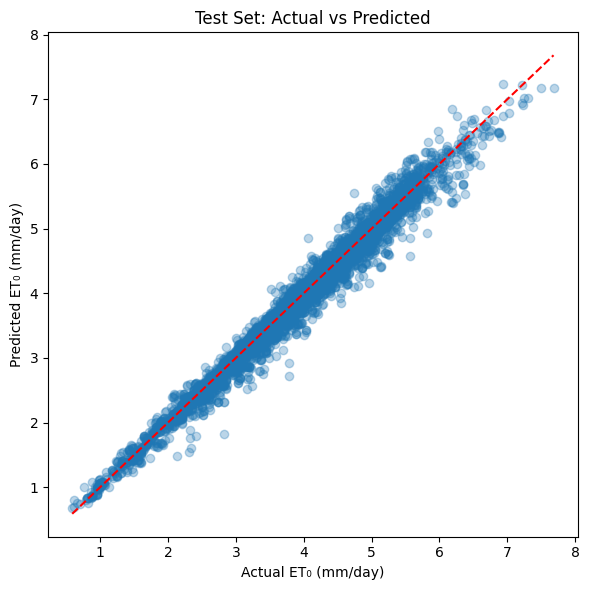

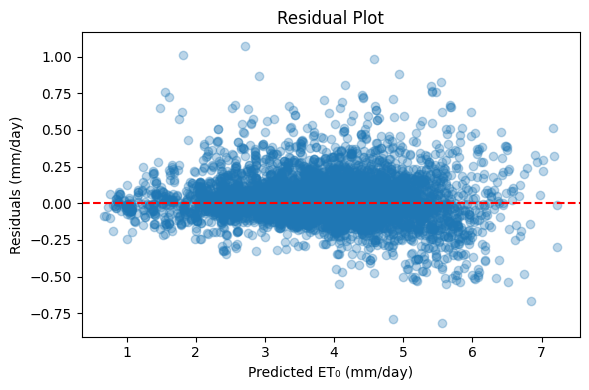

In [8]:
# ------------------------------
# 6. Plot actual vs predicted and residuals
# ------------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual ET₀ (mm/day)')
plt.ylabel('Predicted ET₀ (mm/day)')
plt.title('Test Set: Actual vs Predicted')
plt.tight_layout()
plt.savefig('actual_vs_predicted.png', dpi=150)
plt.show()

residuals = y_test - y_test_pred
plt.figure(figsize=(6,4))
plt.scatter(y_test_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted ET₀ (mm/day)')
plt.ylabel('Residuals (mm/day)')
plt.title('Residual Plot')
plt.tight_layout()
plt.savefig('residuals.png', dpi=150)
plt.show()


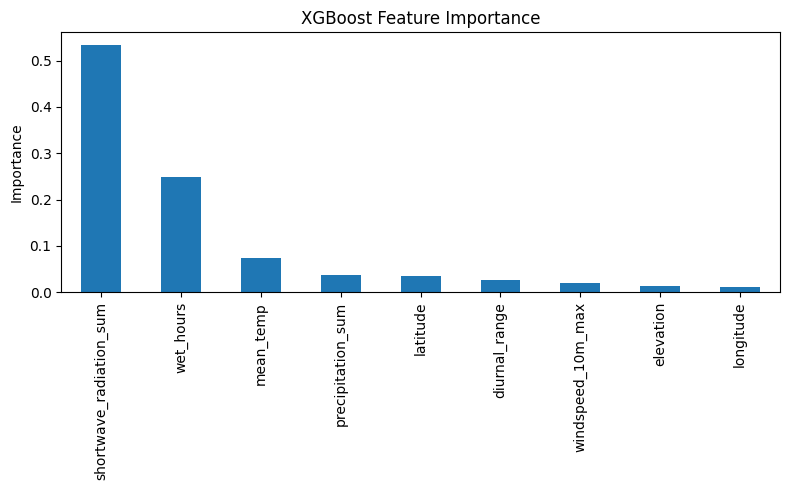

In [9]:
# ------------------------------
# 7. Feature importance (built-in)
# ------------------------------
importance = model.feature_importances_
feat_imp = pd.Series(importance, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
feat_imp.plot(kind='bar')
plt.title('XGBoost Feature Importance')
plt.ylabel('Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

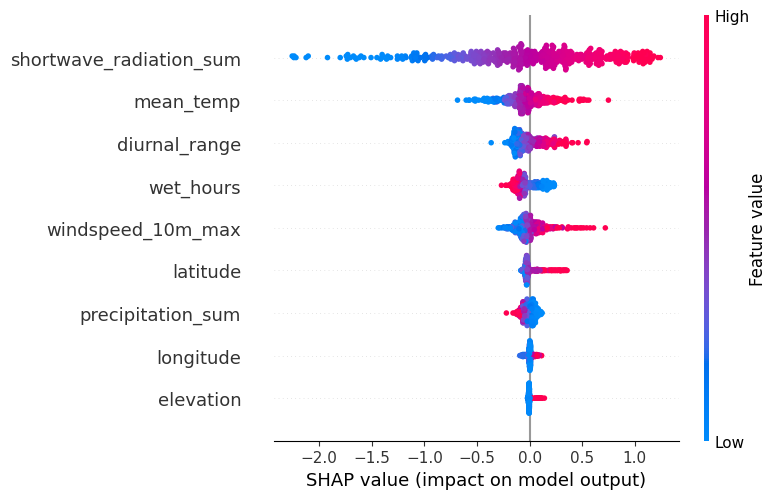

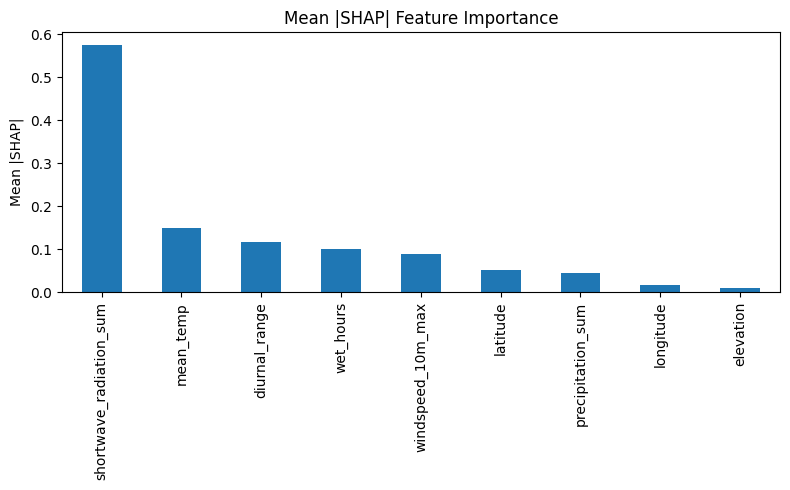

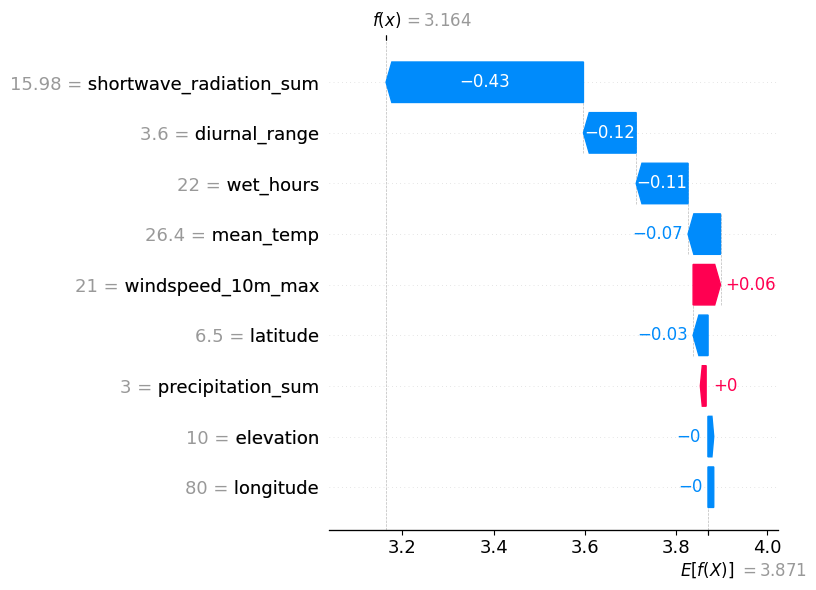

In [11]:
# ------------------------------
# 8. SHAP explainability
# ------------------------------
explainer = shap.TreeExplainer(model)

# Take a sample of test data for SHAP plots (to avoid long runtime)
X_test_sample = X_test.sample(min(500, len(X_test)), random_state=42)
shap_values = explainer.shap_values(X_test_sample)

# Summary plot (beeswarm)
plt.figure()
shap.summary_plot(shap_values, X_test_sample, feature_names=features, show=False)
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=150)
plt.show()

# Mean |SHAP| bar plot
shap_importance = np.abs(shap_values).mean(axis=0)
shap_imp_series = pd.Series(shap_importance, index=features).sort_values(ascending=False)

plt.figure(figsize=(8,5))
shap_imp_series.plot(kind='bar')
plt.title('Mean |SHAP| Feature Importance')
plt.ylabel('Mean |SHAP|')
plt.tight_layout()
plt.savefig('shap_importance.png', dpi=150)
plt.show()

# Waterfall plot for a single prediction (first sample)
shap.waterfall_plot(shap.Explanation(values=shap_values[0],
                                      base_values=explainer.expected_value,
                                      data=X_test_sample.iloc[0].values,
                                      feature_names=features),
                    show=False)
plt.tight_layout()
plt.savefig('shap_waterfall_example.png', dpi=150)
plt.show()

In [12]:
# ------------------------------
# 9. Save model and explainer for deployment
# ------------------------------
joblib.dump(model, 'et0_xgboost_model.pkl')
joblib.dump(explainer, 'shap_explainer.pkl')
print("\nModel saved as 'et0_xgboost_model.pkl'")
print("SHAP explainer saved as 'shap_explainer.pkl'")


Model saved as 'et0_xgboost_model.pkl'
SHAP explainer saved as 'shap_explainer.pkl'
